In [1]:
import math

import torch
import pandas as pd
import plotly.graph_objects as go

from torchtext import data

import warnings as wrn

wrn.filterwarnings('ignore')

In [2]:
SEED = 2021

torch.manual_seed(SEED)
# torch.backends.cuda.deterministic = True

In [3]:
DATA_PATH = 'data/news/preprocessed.csv'

data_ = pd.read_csv(DATA_PATH)
# data_['']
data_.head()

type                                               text
0  FAKE                       You Can Smell Hillary’s Fear
1  FAKE  Watch The Exact Moment Paul Ryan Committed Pol...
2  REAL        Kerry to go to Paris in gesture of sympathy
3  FAKE  Bernie supporters on Twitter erupt in anger ag...
4  REAL   The Battle of New York: Why This Primary Matters

In [4]:
data_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6299 entries, 0 to 6298
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   type    6299 non-null   object
 1   text    6299 non-null   object
dtypes: object(2)
memory usage: 98.5+ KB


In [5]:
# Field is a normal column 
# LabelField is the label column.

TEXT = data.Field(
    tokenize='spacy',
    tokenizer_language='en_core_web_sm',
    batch_first=True, include_lengths=True
)
LABEL = data.LabelField(dtype=torch.float, batch_first=True)

In [6]:
fields = [('type', LABEL), ('text', TEXT)]

In [7]:
training_data = data.TabularDataset(
    path=DATA_PATH,
    format='csv',
    fields=fields,
    skip_header=True
)

print(vars(training_data.examples[0]))

{'type': 'FAKE', 'text': ['You', 'Can', 'Smell', 'Hillary', '’s', 'Fear']}


In [8]:
import random

train_data, valid_data = training_data.split(
    split_ratio=0.75,
    random_state=random.seed(SEED)
)

vars(train_data[0])

{'type': 'FAKE',
 'text': ['Let',
  '’s',
  'Be',
  'Clear',
  '—',
  'A',
  'Vote',
  'for',
  'Warmonger',
  'Hillary',
  'Clinton',
  'Is',
  'a',
  'Vote',
  'for',
  'World',
  'War',
  '3']}

In [9]:
# Building vocabularies => (Token to integer)
TEXT.build_vocab(
    train_data,
    min_freq=5
)

LABEL.build_vocab(train_data)

In [10]:
print("Size of text vocab:", len(TEXT.vocab))

Size of text vocab: 1751


In [11]:
print("Size of label vocab:", len(LABEL.vocab))
LABEL.vocab.freqs.most_common(10)

Size of label vocab: 2


[('REAL', 2390), ('FAKE', 2334)]

In [38]:
LABEL.vocab.itos[0]

'REAL'

In [12]:
TEXT.vocab.freqs.most_common(10)

[(':', 1203),
 (',', 1040),
 ('to', 970),
 ('the', 888),
 ('Trump', 816),
 ('The', 679),
 ('in', 648),
 ('-', 630),
 ('of', 630),
 ('’s', 568)]

In [13]:
device = torch.device('cuda:0')

BATCH_SIZE = 64

# We'll create iterators to get batches of data when we want to use them
"""
This BucketIterator batches the similar length of samples and reduces the need of 
padding tokens. This makes our future model more stable

"""
train_iterator, validation_iterator = data.BucketIterator.splits(
    (train_data, valid_data),
    batch_size=BATCH_SIZE,
    # Sort key is how to sort the samples
    sort_key=lambda x: len(x.text),
    sort_within_batch=True,
    device=device
)

In [14]:
import torch.nn as nn


class LSTMNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, bidirectional, dropout):
        super(LSTMNet, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, text, text_lengths):
        embedded = self.embedding(text)

        packed_embedded = nn.utils.rnn.pack_padded_sequence(
            embedded, text_lengths.cpu(), batch_first=True
        )

        packed_output, (hidden_state, cell_state) = self.lstm(packed_embedded)

        hidden = torch.cat((hidden_state[-2, :, :], hidden_state[-1, :, :]), dim=1)

        dense_outputs = self.fc(hidden)

        outputs = self.sigmoid(dense_outputs)

        return outputs

In [15]:
# We'll use this helper to compute accuracy
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)

    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

In [16]:
def train_epoch(model, iterator, optimizer, criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    model.train()

    for batch in iterator:
        # cleaning the cache of optimizer
        optimizer.zero_grad()

        text, text_lengths = batch.text

        # forward propagation and squeezing
        predictions = model(text, text_lengths).squeeze()

        # computing loss / backward propagation
        loss = criterion(predictions, batch.type)
        loss.backward()

        # accuracy
        acc = binary_accuracy(predictions, batch.type)

        # updating params
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    # It'll return the means of loss and accuracy
    return epoch_loss / len(iterator), epoch_acc / len(iterator)


In [17]:
def evaluate(model, iterator, criterion):
    epoch_loss = 0.0
    epoch_acc = 0.0

    # deactivate the dropouts
    model.eval()

    # Sets require_grad flat False
    with torch.no_grad():
        for batch in iterator:
            text, text_lengths = batch.text

            predictions = model(text, text_lengths).squeeze()

            #compute loss and accuracy
            loss = criterion(predictions, batch.type)
            acc = binary_accuracy(predictions, batch.type)

            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [18]:
from typing import Any


def train(
        m: nn.Module,
        train_iterator_: Any,
        validation_iterator_: Any,
        optimizer_: torch.optim.Optimizer,
        criterion_: Any,
        epochs: int
) -> tuple[float, list[float], float, list[float]]:
    train_losses_ = []
    valid_losses_ = []
    train_acc_ = 0.0
    valid_acc_ = 0.0

    for epoch in range(1, epochs + 1):
        train_loss, train_acc_ = train_epoch(m, train_iterator_, optimizer_, criterion_)
        train_losses_.append(train_loss)

        valid_loss, valid_acc_ = evaluate(m, validation_iterator_, criterion_)
        valid_losses_.append(valid_loss)

        # Showing statistics
        print(f'Epoch: {epoch}/{epochs}')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc_ * 100:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc_ * 100:.2f}%')
        print()

    return train_acc_, train_losses_, valid_acc_, valid_losses_

In [31]:
import torch.optim as optim

SIZE_OF_VOCAB = len(TEXT.vocab)
EMBEDDING_DIM = 300
NUM_HIDDEN_NODES = 128
NUM_OUTPUT_NODES = 1
NUM_LAYERS = 16
BIDIRECTION = False
# DROPOUT = 0
DROPOUT = 0.5

results = {}

EPOCHS_COUNT = 10
MIN_LAYERS = 2
MAX_LAYERS = 16

for num_layers in range(MIN_LAYERS, MAX_LAYERS + 1):
    for j in range(1, 3 + 1):
        print(f'{num_layers=} {j}/3')
        model = LSTMNet(
            SIZE_OF_VOCAB,
            EMBEDDING_DIM,
            NUM_HIDDEN_NODES,
            NUM_OUTPUT_NODES,
            num_layers,
            BIDIRECTION,
            DROPOUT
        )

        model = model.to(device)
        optimizer = optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.BCELoss()
        criterion = criterion.to(device)

        # print(model)

        epochs = int(EPOCHS_COUNT * math.sqrt(num_layers / MIN_LAYERS))
        # print(epochs)
        train_acc, train_losses, valid_acc, valid_losses = train(
            model,
            train_iterator, validation_iterator,
            optimizer, criterion,
            epochs
        )

        if num_layers not in results or valid_acc > results[num_layers]['valid_accuracy']:
            results[num_layers] = {
                'train_losses': train_losses,
                'valid_losses': valid_losses,
                'train_accuracy': train_acc,
                'valid_accuracy': valid_acc,
                'model': model,
            }
            continue

results

num_layers=2 1/3
Epoch: 1/10
	Train Loss: 0.686 | Train Acc: 54.75%
	 Val. Loss: 0.672 |  Val. Acc: 62.79%

Epoch: 2/10
	Train Loss: 0.656 | Train Acc: 66.32%
	 Val. Loss: 0.625 |  Val. Acc: 70.72%

Epoch: 3/10
	Train Loss: 0.572 | Train Acc: 73.00%
	 Val. Loss: 0.511 |  Val. Acc: 76.59%

Epoch: 4/10
	Train Loss: 0.489 | Train Acc: 76.88%
	 Val. Loss: 0.461 |  Val. Acc: 78.21%

Epoch: 5/10
	Train Loss: 0.435 | Train Acc: 80.99%
	 Val. Loss: 0.434 |  Val. Acc: 80.21%

Epoch: 6/10
	Train Loss: 0.399 | Train Acc: 82.91%
	 Val. Loss: 0.409 |  Val. Acc: 81.46%

Epoch: 7/10
	Train Loss: 0.351 | Train Acc: 85.35%
	 Val. Loss: 0.408 |  Val. Acc: 81.67%

Epoch: 8/10
	Train Loss: 0.322 | Train Acc: 87.19%
	 Val. Loss: 0.414 |  Val. Acc: 81.36%

Epoch: 9/10
	Train Loss: 0.292 | Train Acc: 88.21%
	 Val. Loss: 0.399 |  Val. Acc: 82.03%

Epoch: 10/10
	Train Loss: 0.270 | Train Acc: 89.37%
	 Val. Loss: 0.390 |  Val. Acc: 83.30%

num_layers=2 2/3
Epoch: 1/10
	Train Loss: 0.684 | Train Acc: 56.16%
	 Va

{2: {'train_losses': [0.685938569339546,
   0.6559095833752606,
   0.571570229288694,
   0.4885784355369774,
   0.4347584851690241,
   0.39940264780779144,
   0.3513811687762673,
   0.3216544270918176,
   0.2923457262081069,
   0.2700703692798679],
  'valid_losses': [0.6720697617530823,
   0.6251122546195984,
   0.5114523398876191,
   0.4612199246883392,
   0.434458070397377,
   0.4092494171857834,
   0.40842727065086365,
   0.4138732200860977,
   0.39904639542102815,
   0.3902692079544067],
  'train_accuracy': 0.893743503738094,
  'valid_accuracy': 0.8329967951774597,
  'model': LSTMNet(
    (embedding): Embedding(1751, 300)
    (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.5)
    (fc): Linear(in_features=256, out_features=1, bias=True)
    (sigmoid): Sigmoid()
  )},
 3: {'train_losses': [0.6876425437025122,
   0.645010526921298,
   0.5335176119933257,
   0.46287619463495305,
   0.41129103987603577,
   0.3710010424256325,
   0.3311463214859769,
   0.300749484248258,

In [32]:
import pickle


with open('results-dropout-0.5.pkl', mode='wb') as f:
    pickle.dump(results, f)

In [34]:
valid_accuracy_per_num_layers = []
for num_layers, result in sorted(results.items(), key=lambda it: it[0]):
    print(f'{num_layers=} valid_accuracy={100 * result["valid_accuracy"]:.2f}')
    valid_accuracy_per_num_layers.append(result["valid_accuracy"])


fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(2, MAX_LAYERS)), y=valid_accuracy_per_num_layers))
fig.update_layout(
        title=f'Accuracy',
        xaxis_title='Number of LSTM layers',
        yaxis_title='Accuracy (Valid)',
        yaxis_range=[0, 1]
    )
fig.show()

num_layers=2 valid_accuracy=83.30
num_layers=3 valid_accuracy=83.17
num_layers=4 valid_accuracy=82.59
num_layers=5 valid_accuracy=83.26
num_layers=6 valid_accuracy=82.19
num_layers=7 valid_accuracy=82.69
num_layers=8 valid_accuracy=82.17
num_layers=9 valid_accuracy=82.36
num_layers=10 valid_accuracy=83.05
num_layers=11 valid_accuracy=83.55
num_layers=12 valid_accuracy=82.70
num_layers=13 valid_accuracy=83.13
num_layers=14 valid_accuracy=81.86
num_layers=15 valid_accuracy=81.13
num_layers=16 valid_accuracy=80.71


In [35]:
def plot_loss(
        title: str,
        epochs_count_: int,
        train_: list[float],
        valid_: list[float]
) -> None:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=list(range(1, epochs_count_)), y=train_, name='Train'))
    fig.add_trace(go.Scatter(x=list(range(1, epochs_count_)), y=valid_, name='Valid'))
    fig.update_layout(
        title=title,
        xaxis_title='Epoch',
        yaxis_title='Loss',
        yaxis_range=[0, 1]
    )
    fig.show()

# TODO plot accuracy
num_layers = 2
plot_loss(
    f'BCE Loss ({num_layers=})',
    EPOCHS_COUNT,
    results[num_layers]['train_losses'],
    results[num_layers]['valid_losses']
)

              precision    recall  f1-score   support

        FAKE       0.82      0.85      0.84       794
        REAL       0.84      0.82      0.83       781

    accuracy                           0.83      1575
   macro avg       0.83      0.83      0.83      1575
weighted avg       0.83      0.83      0.83      1575



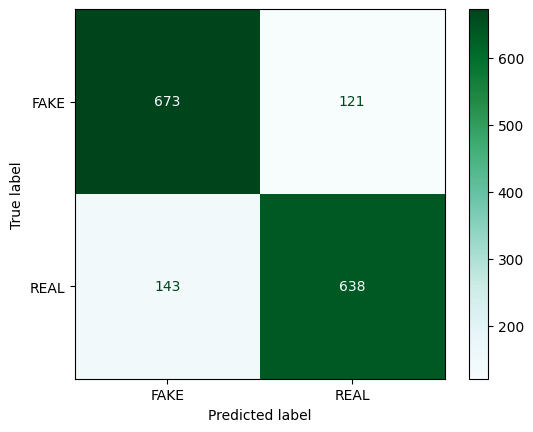

In [36]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import numpy as np
from matplotlib import pyplot as plt


def lut(labels: list[str], indices: np.ndarray) -> list[str]:
    result = [None] * len(indices)
    for i, index in enumerate(indices.astype('int32')):
        result[i] = labels[index]
    return result


predictions = []
true_labels = []
with torch.no_grad():
    for batch in validation_iterator:
        text, text_lengths = batch.text
        predictions.append(results[num_layers]['model'](text, text_lengths).squeeze().cpu().numpy())
        true_labels.append(batch.type.cpu().numpy())

y_pred = np.concatenate(predictions) > 0.5
y_true = np.concatenate(true_labels)
y_pred = lut(LABEL.vocab.itos, y_pred)
y_true = lut(LABEL.vocab.itos, y_true)

print(classification_report(y_true, y_pred))
ConfusionMatrixDisplay.from_predictions(
    y_true, y_pred,
    cmap='BuGn'
)
plt.grid(False)
plt.show()